In [2]:
! pip install celluloid

In [3]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2

from IPython.display import HTML

In [4]:
import torch
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [5]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

### Inspection

In [6]:
root = Path("../input/medical-segmentation-decathlon-lung/imagesTr/")
label = Path("../input/medical-segmentation-decathlon-lung/labelsTr")

In [7]:
def change_img_to_label_path(path):
    
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

Load sample image

In [8]:
sample_path= list(root.glob("*/lung*"))[2]
sample_path_label = change_img_to_label_path(sample_path)

In [9]:
sample_path, sample_path_label

(PosixPath('../input/medical-segmentation-decathlon-lung/imagesTr/lung_051.nii/lung_051.nii'),
 PosixPath('../input/medical-segmentation-decathlon-lung/labelsTr/lung_051.nii/lung_051.nii'))

Load NifTI and extract image data

In [10]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

In [11]:
ct.shape, mask.shape

((512, 512, 155), (512, 512, 155))

Find out orientation

In [12]:
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

Orientation: Left to Right=Sagittal, Anterior to Posterior=Coronal, Supeior to Inferior=Axial

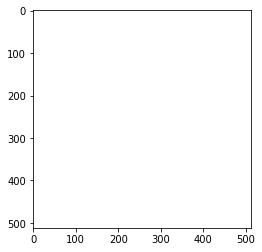

In [13]:
fig = plt.figure()
camera = Camera(fig)

for i in range(0, ct.shape[2], 2): # axial view
    plt.imshow(ct[:, :, i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:, :, i]==0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    camera.snap()

animation = camera.animate()

In [14]:
HTML(animation.to_html5_video())

### Perprocessing

In [15]:
all_files = list(root.glob("*/lung_*"))
len(all_files)

63

In [16]:
save_root = Path("preprocessed")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):
    
    path_to_label = change_img_to_label_path(path_to_ct_data)
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()
    
    # crop volume and label - remove first 30 slides
    ct_data = ct_data[:, :, 30:]/3071
    label_data = label_data[:, :, 30:]
    
    # check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
        
    for i in range(ct_data.shape[-1]):
        slice_ = ct_data[:, :, i]
        mask_ = label_data[:, :, i]
        
        slice_ = cv2.resize(slice_, (256, 256))
        mask_ = cv2.resize(mask_, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice_)
        np.save(mask_path/str(i), mask_)
    

  0%|          | 0/63 [00:00<?, ?it/s]

### Validate perprocessed data

In [46]:
path = Path("preprocessed/train/2")
list(path.glob("*"))

[PosixPath('preprocessed/train/2/data'),
 PosixPath('preprocessed/train/2/masks')]

In [47]:
len(list(list(path.glob("*"))[0].glob("*")))

125

Choose a file and load slice + mask

In [48]:
file = "120.npy"
slice_ = np.load(path/"data"/file)
mask_ = np.load(path/"masks"/file)

slice_.shape, mask_.shape

((256, 256), (256, 256))

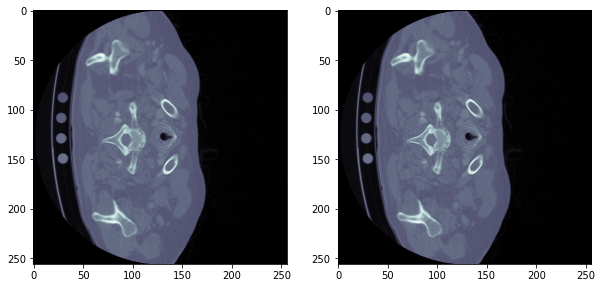

In [49]:
fig, axis = plt.subplots(1, 2, figsize=(10, 10))
axis[0].imshow(slice_, cmap="bone")
mask_ = np.ma.masked_where(mask_==0, mask_)
axis[1].imshow(slice_, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

In [50]:
print(slice_.min(), slice_.max())

-0.33344187561055033 0.4487951807228916


### Dataset Class

In [51]:
class LungDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
        
    @staticmethod
    def extract_files(root):
        files = []
        
        for subject in root.glob("*"):
            slice_path = subject/"data"
            for slice_ in slice_path.glob("*.npy"):
                files.append(slice_)
        return files
    
    @staticmethod
    def change_img_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)
    
    def augment(self, slice_, mask_):
        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)
        
        mask_ = SegmentationMapsOnImage(mask_, mask_.shape)
        slice_aug, mask_aug = self.augment_params(image=slice_, segmentation_maps=mask_)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice_ = np.load(file_path).astype(np.float32)
        mask_ = np.load(mask_path)
        
        if self.augment_params:
            slice_, mask_ = self.augment(slice_, mask_)
            
        return np.expand_dims(slice_, 0), np.expand_dims(mask_, 0)

Test our dataset

In [52]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
    ])

In [53]:
path = Path("preprocessed/train/")
dataset = LungDataset(path, seq)

In [54]:
len(dataset)

14179

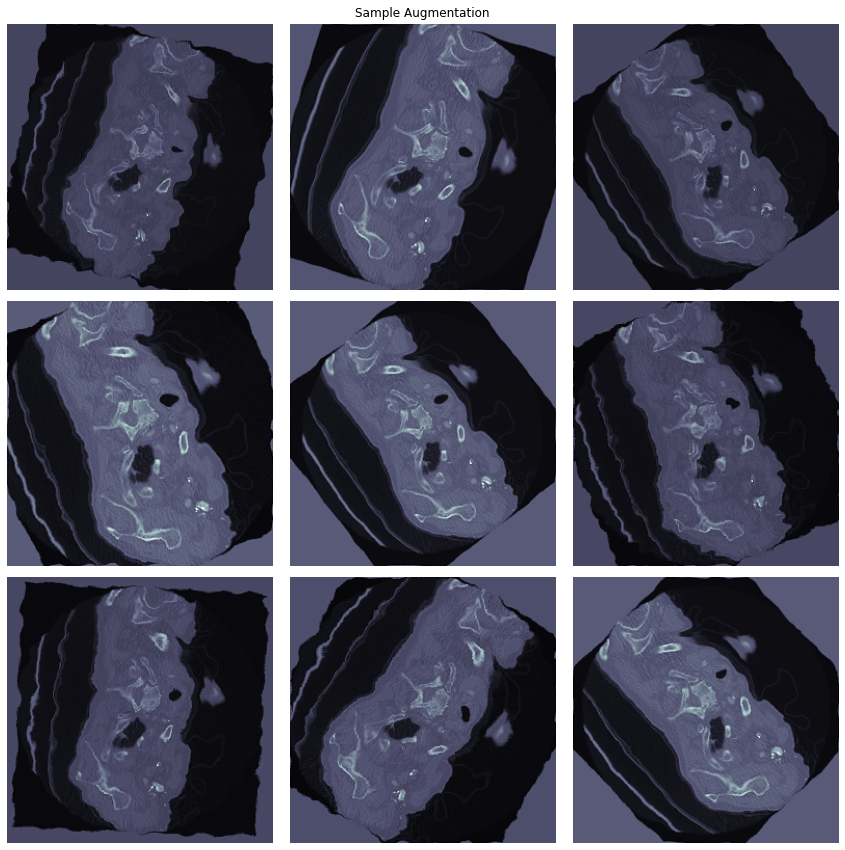

In [55]:
fig, axis = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    for j in range(3):
        
        slice_, mask_ = dataset[19]
        
        mask_ = np.ma.masked_where(mask_==0, mask_)
        axis[i][j].imshow(slice_[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")
        
fig.suptitle("Sample Augmentation")
plt.tight_layout()

### Model Class

Convolutions

In [56]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.step = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
            torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)

UNET

In [57]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        
        # decoder
        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        
        self.maxpool =  torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        
        # encoder
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)
        
        # decoder
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret

Testing Model

In [58]:
model = UNet()

In [59]:
random_input = torch.randn(1, 1, 256, 256)
output = model(random_input)
assert output.shape == torch.Size([1, 1, 256, 256])

### Dataset Creation

In [60]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
    ])

In [61]:
train_path = Path("preprocessed/train")
val_path = Path("preprocessed/val/")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images.")

There are 14179 train images and 1588 val images.


### Oversampling

In [ ]:
# list containing only class labels

target_list = []
for _, label in tqdm(train_dataset):
    if np.any(label):
        target_list.append(1)
    else:
        target_list.append(0)


In [63]:
# number of samples in each class
uniques = np.unique(target_list, return_counts=True)
uniques

(array([0, 1]), array([424,  64]))

In [35]:
# calculate the weight for each class - compute the fraction between classes
fraction = uniques[1][0] / uniques[1][1]
fraction

8.503351206434317

In [36]:
# assign weight 1 to each slice without a tumor and ~9 to each slice with tumor
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [64]:
weight_list[:5]

[1, 1, 1, 1, 1]

WeightedRandomSampler

In [65]:
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))

### DataLoader

In [66]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [67]:
# verify our sampler
verify_sampler = next(iter(train_loader))

verify_sampler[1][:, 0].shape

torch.Size([8, 256, 256])

In [68]:
(verify_sampler[1][:, 0]).sum([1, 2]) > 0

tensor([ True,  True,  True, False, False, False, False, False])

### Full Segmentation Model Class

In [69]:
class TumorSegmentation(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss()
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        pred = self(ct)
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        ct, mask = batch
        mask = mask.float()
        pred = self(ct)
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        if batch_idx % 50 == 0:
            self.log_images(ct.cpu(), pred.cpu(), mask.cpu(), "Val")
        return loss
    
    def log_images(self, ct, pred, mask, name):
        results = []
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0]==0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(ct[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0]==0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        
        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]
        

In [70]:
model = TumorSegmentation()

In [71]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='min'
    )

In [72]:
# accelerator = 'gpu'
accelerator = "cuda:0" if torch.cuda.is_available() else "cpu"
devices = 1

trainer = pl.Trainer(
    accelerator=accelerator, 
    devices=devices,
    logger=TensorBoardLogger(save_dir="logs"),
    log_every_n_steps=1, 
    callbacks = checkpoint_callback,
    max_epochs=30
)

In [73]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Evaluation

In [74]:
class DiceScore(torch.nn.Module):
    def __init__(self, pred, mask):
        super().__init__()
        
    def forward(self, pred, mask):
        
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred*mask).sum()
        denum = pred.sum() + mask.sum()
        dice = (2*counter)/denum
        return dice

In [75]:
model = TumorSegmentation.load_from_checkpoint("../input/medical-segmentation-decathlon-lung/unet-weights-lung/epoch-29-step-53759.ckpt")
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

TumorSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): 

In [77]:
preds = []
labels = []

for slice_, label in tqdm(val_dataset):
    slice_ = torch.tensor(slice_).float().to(device).unsqueeze(0)
    with torch.no_grad():
        pred = torch.sigmoid(model(slice_))
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1588 [00:00<?, ?it/s]

In [ ]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

### Visualization

In [ ]:
THRESHOLD = 0.5

In [ ]:
subject = Path("../input/medical-segmentation-decathlon-lung/imagesTs/lung_013.nii/lung_013.nii")
ct = nib.load(subject).get_fdata() / 3071
ct = ct[:, :, 30:]

In [ ]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice_ = ct[:, :, i]
    slice_ = cv2.resize(slice_, (256, 256))
    slice_ = torch.tensor(slice_)
    scan.append(slice_)
    slice_ = slice_.unsqueeze(0).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        pred = model(slice_)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)

In [ ]:
# plotting the predicted segmentation red
fig = plt.acorrfig()
camera = Camera(fig)
for i in rage(0, len(scan), 2):
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    
    plt.axis("off")
    camera.snap()
    
animation = camera.animate()

In [ ]:
HTML(animation.to_html5_video())